In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from pandas_profiling import ProfileReport
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import yaml
from sklearn.manifold import TSNE

def load_params(param_path: str):
    with open(param_path, "r") as f:
        return yaml.safe_load(f)

In [2]:
params_yaml = load_params("../params.yaml")['amazon']

df_test = pd.read_json(f"{params_yaml['feature_extraction']['test_features_appended']}/TestFeaturesAppendedamazon.json")
df_train = pd.read_json(f"{params_yaml['feature_extraction']['train_features_appended']}/TrainFeaturesAppendedamazon.json")
# Mamy zajmować się analizą dla treningu, więc operować będę na danych trenignowych
X_train = df_train.drop(columns='overall')
y_train = df_train['overall']

### Sprawdzenie rozkładu klas w zbiorze

Jak widać klasy nie są równoliczne, co może powodować późniejsze problemy.

In [3]:
print(df_train.groupby("overall").size())

overall
1     1341
2      684
3     1898
4     3111
5    11081
dtype: int64


In [4]:
X_train.describe()

,unixReviewTime,Package Quantity:,reviewLength,freshness
count,1.811500e+04,1.0,18115.000000,18115.000000
mean,1.399584e+09,1.0,744.021419,1570.114160
std,9.976582e+07,NaN,1206.732291,1154.697022
min,9.669888e+08,1.0,0.000000,0.000000
25%,1.352592e+09,1.0,88.000000,669.000000
50%,1.425082e+09,1.0,296.000000,1275.000000
75%,1.477440e+09,1.0,992.000000,2114.000000
max,1.535242e+09,1.0,30392.000000,6577.000000


Powyższa tabela przedstawia dane numeryczne. Można dojść do wniosku, że recenzje na stronie są raczej dobre - ich średnia to 4.2. Długość recenzji różni się - można podejrzewać, że te oceniane najbardziej skrajnie posiadają najdłuższe recenzje. Atrybut freshness informuje nas o tym ile dni minęło między recenzją, a datą a najnowszej recenzji.

### Sprawdzenie rodzaju danych dla cech

In [5]:
print(f"Nazwy kolumn: {df_train.columns.values}")
print(f"Liczba danych kategorycznych: {np.sum(X_train.dtypes == 'object')}")
print(f"Liczba danych numerycznych: {np.sum(X_train.dtypes == 'int64') + np.sum(X_train.dtypes == 'float64')}")
print(f"Liczba danych typu bool: {np.sum(X_train.dtypes == 'bool')}")

Nazwy kolumn: ['verified' 'reviewTime' 'reviewerID' 'asin' 'reviewerName' 'reviewText'
 'summary' 'unixReviewTime' 'vote' 'image' 'category' 'Size:' 'Flavor:'
 'Color:' 'Scent Name:' 'Style Name:' 'Design:' 'Size Name:' 'Style:'
 'Package Quantity:' 'Format:' 'Platform:' 'Package Type:' 'overall'
 'isBoughtForChristmas' 'reviewLength' 'freshness']
Liczba danych kategorycznych: 20
Liczba danych numerycznych: 4
Liczba danych typu bool: 2


### Sprawdzenie rodzaju zmiennej wyjściowej

In [6]:
print(f"Rodzaj zmiennej wyjściowej: {y_train.dtypes}")

Rodzaj zmiennej wyjściowej: int64


### Wizualizacja za pomocą t-SNE 

In [7]:
from sklearn.preprocessing import StandardScaler
x = X_train.select_dtypes(include='number')
x = x.fillna(x.median())
standarized_data = StandardScaler().fit_transform(x)
tsne = TSNE(n_components=2, perplexity=50, learning_rate=200)
tsne_df = pd.DataFrame(data=tsne.fit_transform(standarized_data), columns=['principal_1', "principal_2"])
tsne_df = pd.concat([tsne_df, y_train], axis=1)

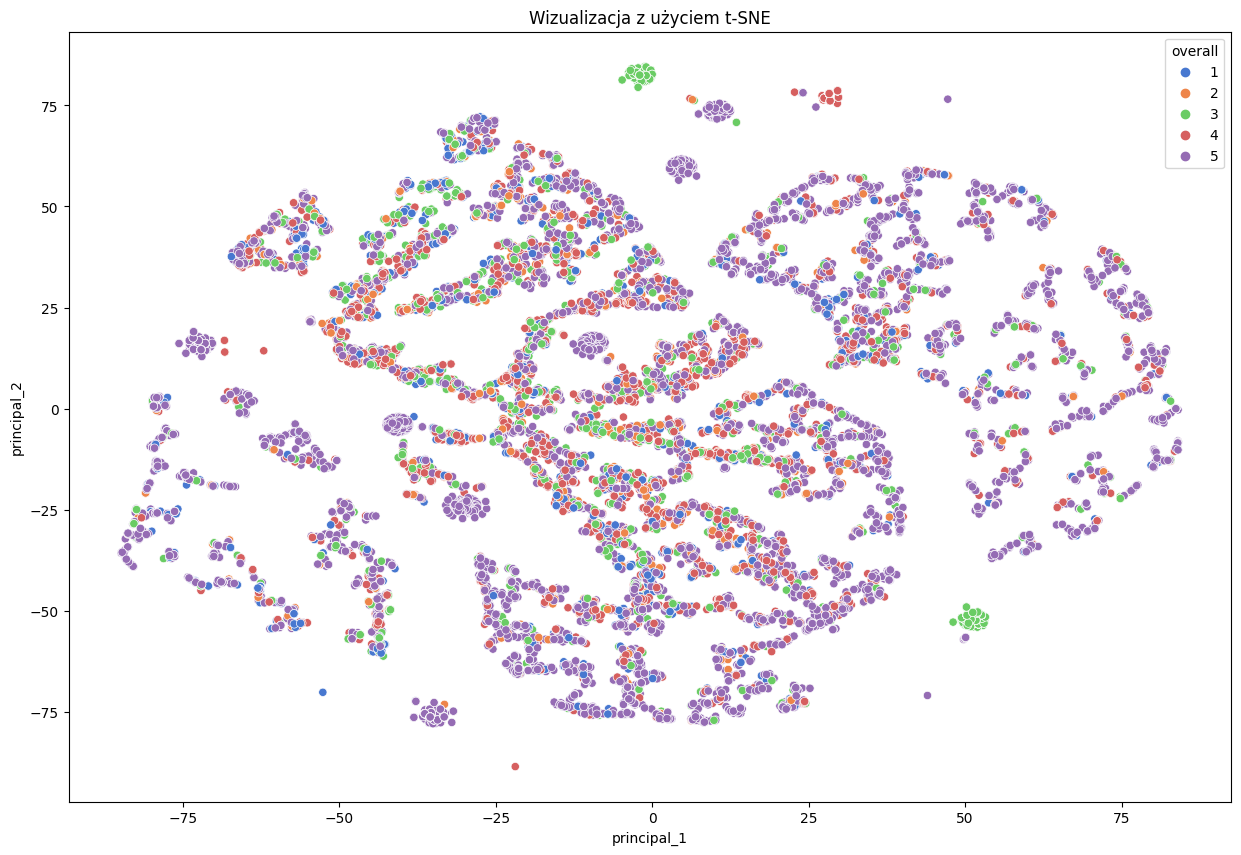

In [8]:
fig, ax=plt.subplots(figsize=(15, 10))
sns.scatterplot(
    x="principal_1",
    y="principal_2",
    hue="overall",
    palette='muted',
    data=tsne_df
).set_title("Wizualizacja z użyciem t-SNE")
plt.show()

### Czy i ile w zbiorze jest brakujących wartości? Dla jakich zmiennych? Co z tego wynika?

In [9]:
print(X_train.isnull().values.any())
print(f"Number of null places {X_train.isnull().sum().sum()}")

True
Number of null places 233125


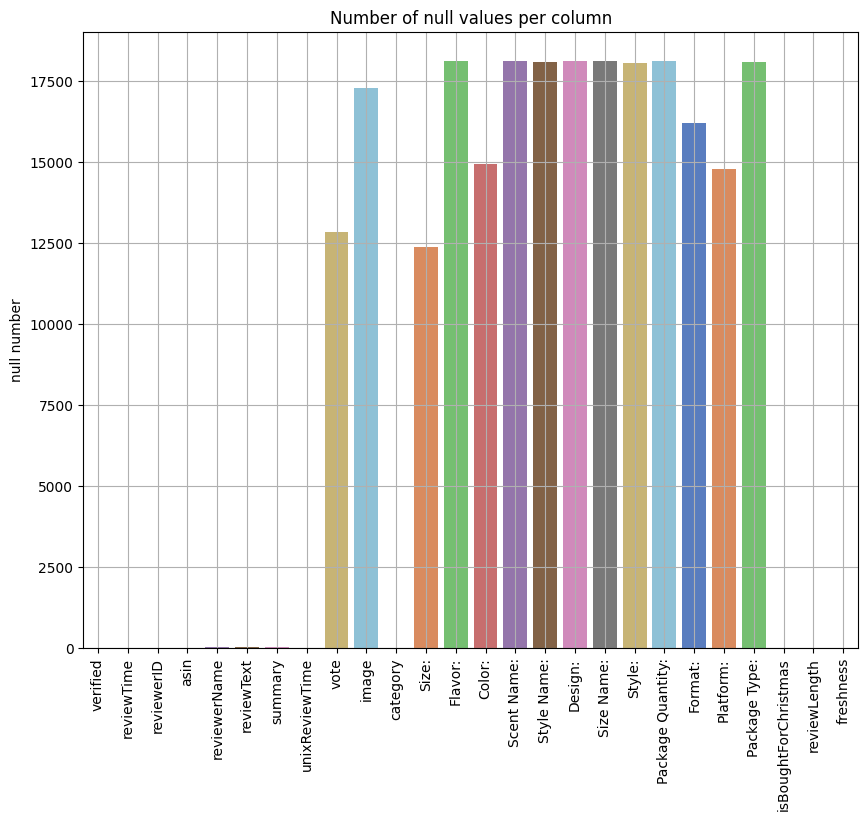

In [10]:
null_set = {}
for col in X_train.columns:
    null_set[col] = X_train[{col}].isnull().sum().to_numpy()[0]

df = pd.DataFrame.from_dict(null_set, orient='index', columns=['null number'])

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=df.index, y='null number', data=df, palette='muted').set(title='Number of null values per column')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

Z powyższej analizy wynika, że jak już pojawiają się wartości typu NULL, to jest ich bardzo dużo. Najwięcej w kolumnach dotyczących stylu. Wynika to z tego, że konkretny rodzaj stylu był inny dla różnych produktów. Niesie to ze sobą ryzyko, że z tych kolumn nie będzie można wynieść za dużo informacji.

### Czy któreś z cech są skorelowane? Co z tego może wynikać?

In [11]:
correlation_matrix = X_train.corr()

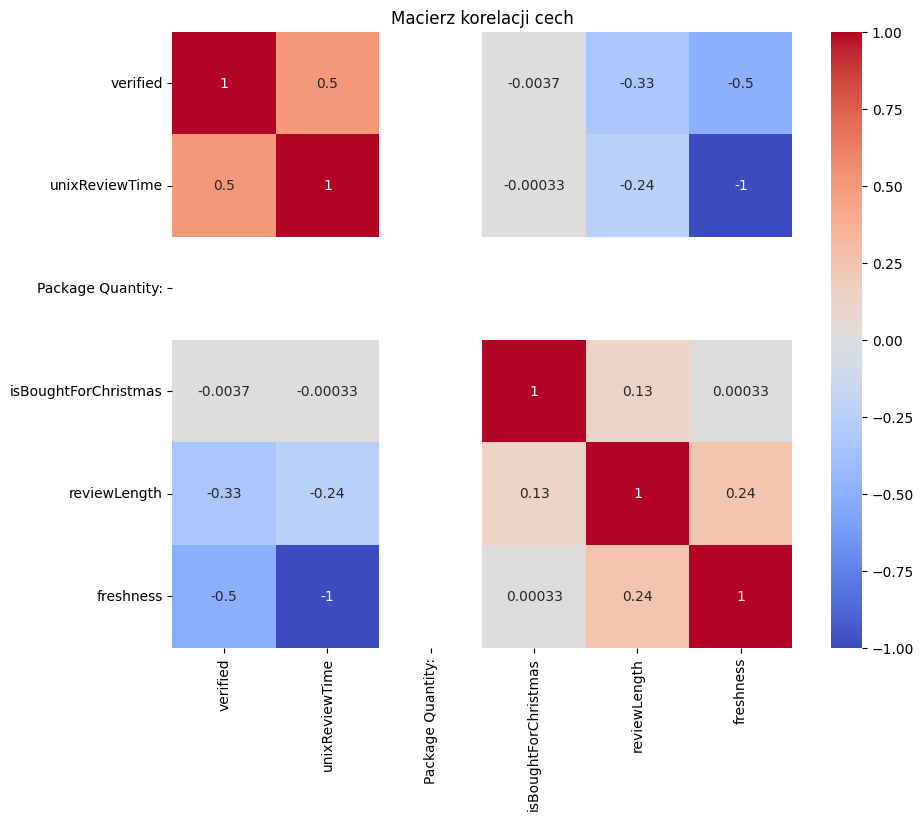

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm").set(title='Macierz korelacji cech')
plt.show()

Z powyższej macierzy korelacji wynika, że cecha freshness jest ujemnie skorelowana z unixReviewTime, co wynika z definicji tej cechy - mówi ona o czasie od najnowszej recenzji. Można się zasugerować, czy nie opłaca się zrezygnować z jednej z cech. Dość silnie skorelowana jest także freshness z verified - ich miara wynosi 0.5, co może oznaczać, że aby zweryfikować recenzje musi upłynąć trochę czasu i recenzje z niższym wskaźnikiem freshness nie zdążyły być jeszcze zakwalifikowane jako 'verified'.

### Czy któraś z cech koreluje ze zmienną wyjściową? Jeśli tak - która? Czy któraś nie koreluje?

In [13]:
correlation_matrix_whole_set = df_train.corr()

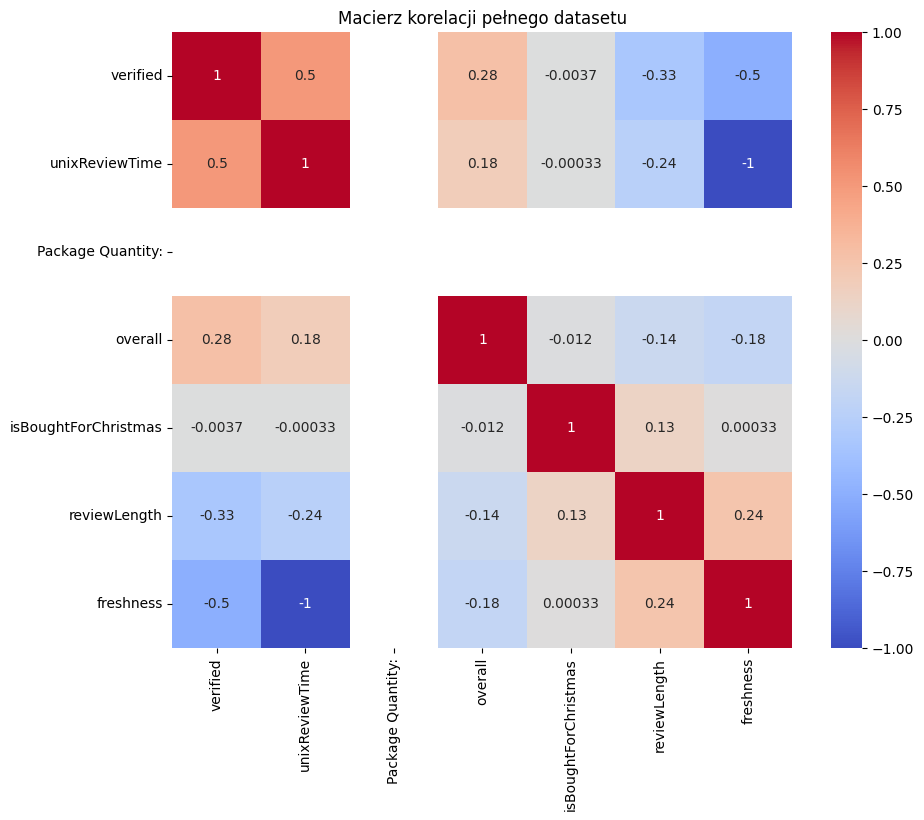

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(correlation_matrix_whole_set, annot=True, cmap="coolwarm").set(title='Macierz korelacji pełnego datasetu')
plt.show()

Z powyższej analizy wynika, że cecha isBoughtForChristmas najsłabiej koreluje ze zmienną wyjściową - jej zmiana nie powoduje zmiany wyjścia. Podobnie słabo skorelowana jest reszta cech numerycznych.

### Czy zbiór danych wydaje się być wystarczająco informacyjny by rozwiązać zadanie analizy sentymentu?


Do tej pory przeanalizowana została część numeryczna zbioru potrzebnego do analizy sentymentu. Z danych wynika, że najprawdopodobniej nie bylibyśmy w stanie poprawnie przeanalizować sentymentu mając do dyspozycji jedynie dane numerczyne, bez kategorycznych.

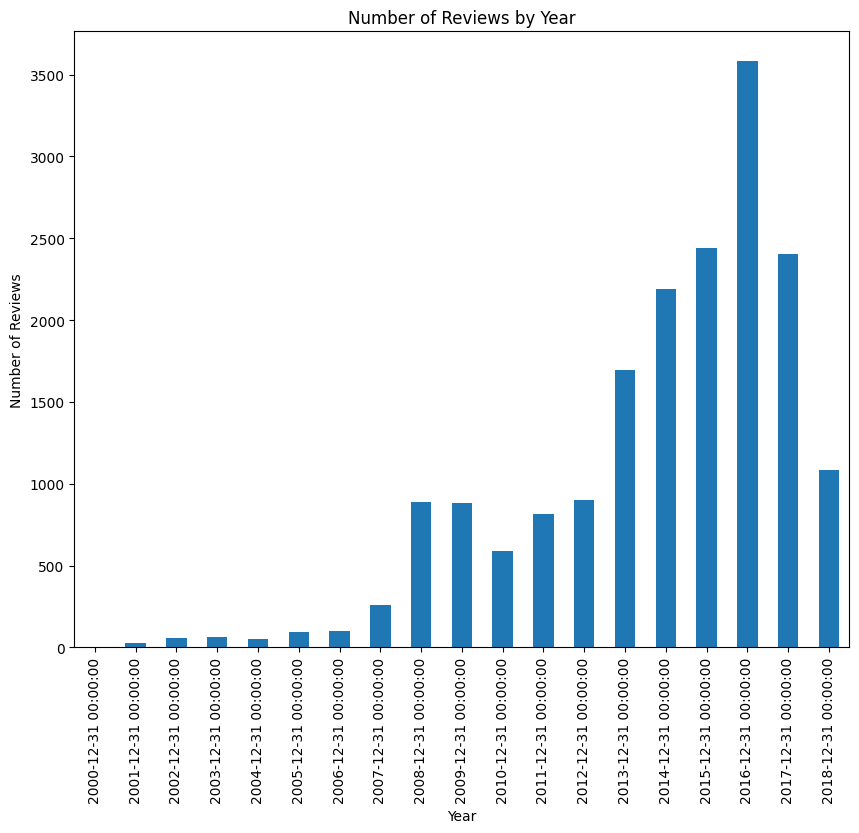

In [15]:
df_train['reviewTime'] = pd.to_datetime(df_train['reviewTime'])
reviews_by_month = df_train.groupby(pd.Grouper(key='reviewTime', freq='Y')).size()

fig, ax = plt.subplots(figsize=(10, 8))
reviews_by_month.plot(kind='bar')
plt.title('Number of Reviews by Year')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')

# Display the plot
plt.show()

Jak widać powyżej najwięcej recenzji było w 2016 roku, potem liczba zaczęła spadać, co może sugerować spadek zainteresowania produktami.


In [16]:
profile = ProfileReport(df_train)
profile.to_file(f"{params_yaml['reports']['pandas_report']}")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Przebadanie ile średnio jest tekstu w zależności od klasy

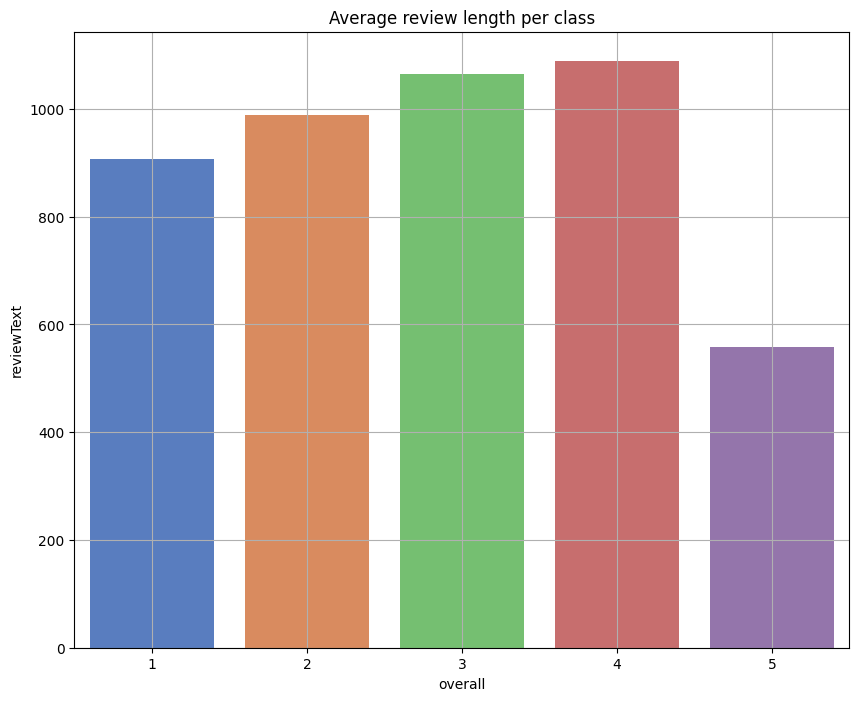

In [17]:
average_text_length_by_class = df_train.groupby("overall")["reviewText"].apply(lambda x: x.str.len().mean()).reset_index()
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x="overall", y='reviewText', data=average_text_length_by_class, palette='muted').set(title='Average review length per class')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.grid(True)
plt.show()

In [18]:
df_train.overall.value_counts()

5    11081
4     3111
3     1898
1     1341
2      684
Name: overall, dtype: int64

## Dane tekstowe

In [19]:
nltk.download('stopwords')
stop = stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/myuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
df_train["tokenized_review"] = df_train["reviewText"].str.lower().str.split()
df_exploded = df_train.explode("tokenized_review").reset_index(drop=True).rename(columns={"tokenized_review": "word"})
df_exploded.shape

(2435379, 28)

In [21]:
df_exploded = df_exploded[~df_exploded["word"].isin(stop)]
print(df_exploded.shape)

(1301528, 28)


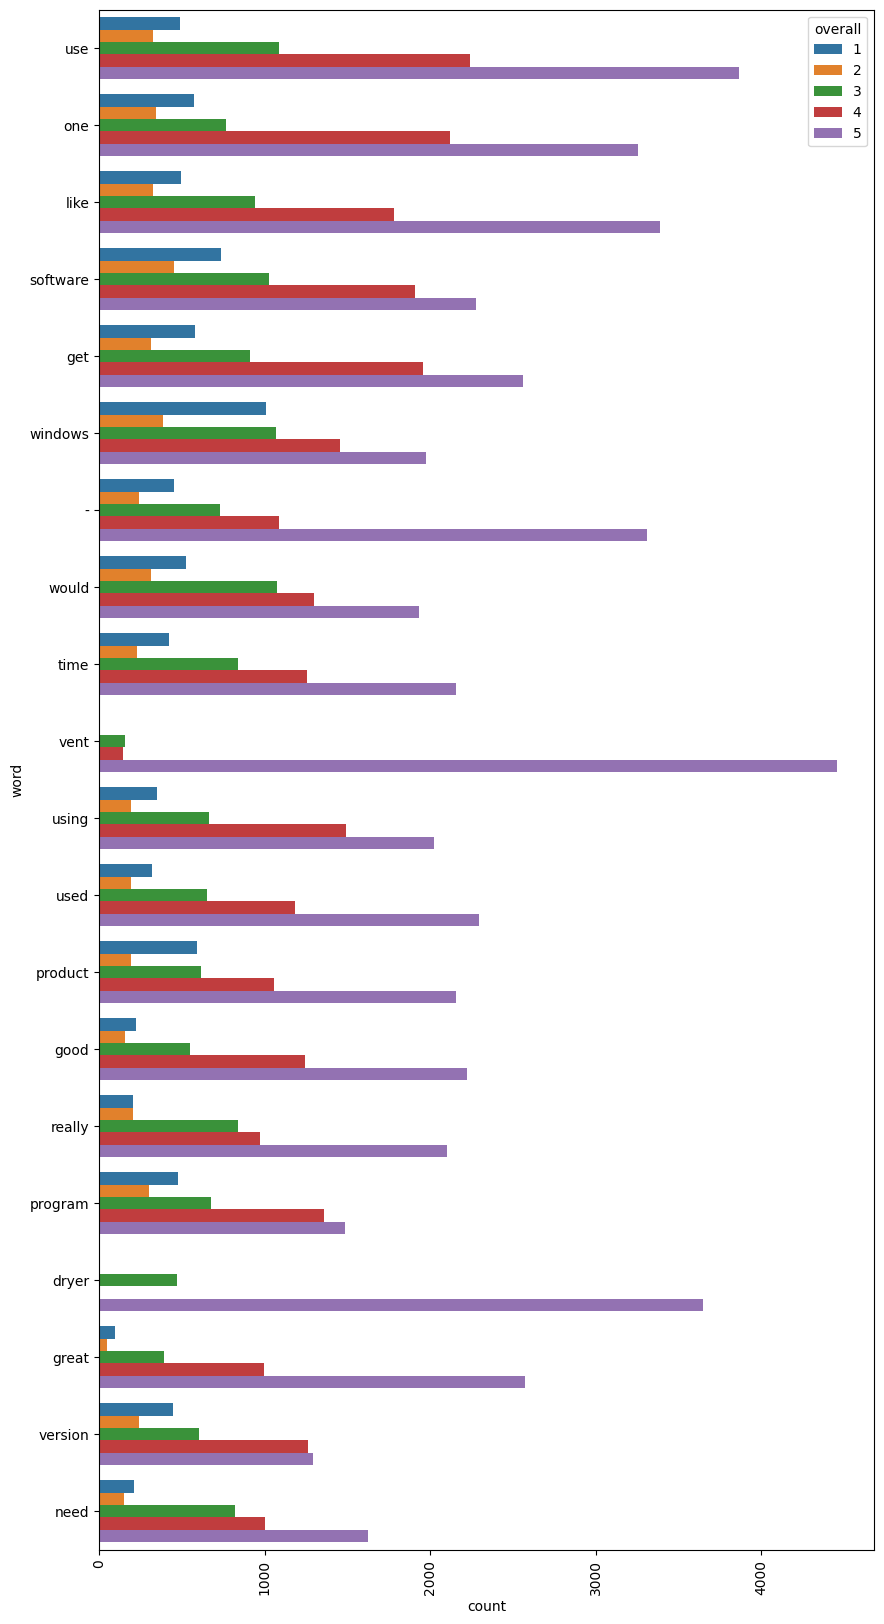

In [22]:
plt.figure(figsize=(10, 20))
sns.countplot(
    y="word",
    data=df_exploded,
    order=df_exploded["word"].value_counts().iloc[:20].index,
    hue="overall",
)
plt.xticks(rotation=90)
plt.show()

In [23]:
df_filtered = df_exploded[df_exploded["word"].isin(["use", "used", "one", "like", "software"])]

print(df_filtered["word"].value_counts())

use         8006
one         7054
like        6934
software    6398
used        4639
Name: word, dtype: int64


Jak widać, mimo krótszych wypowiedzi podczas dobrej oceny słowa use, vent, dryer, great są bardzo popularne w gdy produkt oceniany był na 5. Całkowicie zbiór wydaje się dominować słowo dryer, use/used - co sugeruje, że opisy dotyczą faktycznie korzystania z produktów i są konstruktywnymi opiniami. Należy jednak zwrócić uwagę Na liczność klas. Ocen bardzo dobrych jest dużo więcej niż tych na 2. Dominują słowa use i used. Które wpływają w znacznym stopniu na sentyment.


Można także zauważyć, że mimo mniejszej liczności słów w tekście ocen dobrych najpopularniejsze słowa zostały zdominowane przez tę klasę, co sugeruje, że oceniający wykorzystują podobny zasób słownictwa, gdy wypowiadają się dobrze o produkcie. Widać także, że oceny 4 zajmują drugie miejsce pod względem liczności najpopularniejszych słów.


### Normalizacja długości

In [24]:
vectorizer = TfidfVectorizer(stop_words='english', min_df=2)
X_train_tfidf = vectorizer.fit_transform(X_train)
# na wykładzie dotychczas nie było nic o normalizacji i równoważeniu klas.
# jedyne co znalazłem to TfidfVectorizer - nie umiałem wykorzystać tego, bo nie do końca rozumiem jak przedstawić zrównoważenie na wykresie

In [25]:
# remove special characters and numbers
df_train["clean_text"] = df_train["reviewText"].str.lower().str.replace(r'[^a-zA-Z\s]', '')

df_train["original_and_clean_diff"] = df_train['reviewLength'] - df_train["clean_text"].str.len()

### Analiza ile znaków było przed usunięciem

In [26]:
print(df_train["reviewLength"].describe())

count    18115.000000
mean       744.021419
std       1206.732291
min          0.000000
25%         88.000000
50%        296.000000
75%        992.000000
max      30392.000000
Name: reviewLength, dtype: float64


### Analiza ile znaków usunięto

In [27]:
print(df_train["original_and_clean_diff"].describe())

count    18098.000000
mean        27.362913
std         55.052758
min          0.000000
25%          3.000000
50%          9.000000
75%         31.000000
max       1226.000000
Name: original_and_clean_diff, dtype: float64


Jak widać tekst można ocenić dobrze. Średnio na recenzję usuwano 27 znaków. Odejmując to od średnio 744 nie jest to zły znak. Można więc ocenić, że średnia długość 744 świadczy o tym, że recenzje są stosunkowo długie i czyste. Niepokojące jest odchylenie standardowe, które w obu przypadkach jest bardzo duże. Świadczy to o tym, że niektóre recenzje mogą składać się jedynie ze znaków specjalnych, bądź liczb.